In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


%matplotlib inline


In [2]:
class NeuralNetwork():
    def __init__(self,X,Y,nn_layers,n_iters=2000,alpha = 0.01,lambda_=10):
        self.X = X
        self.Y = Y
        self.nn_layers= nn_layers
        self.n_iters= n_iters
        self.alpha= alpha
        self.lambda_= lambda_
        self.params = self.random_weights_initialization(nn_layers)
        
    def tanh(self,z):
        return np.tanh(z)
    def sigmoid(self,z):
        return 1 / (1+np.exp(-z))
    def sigmoid_deriv(self,z):# z --> sigmoid(Z)
        return z * (1-z)
    def tanh_deriv(self,z): # z --> tanh(Z)
        return 1 - (z)**2
    def relu(self,Z):
        z_copy = np.array(Z,copy=True)
        return np.maximum(0,z_copy)
    def relu_backward(self,dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def random_weights_initialization(self,n_layers):
        params = {}

        # n_layers --> (len-1) is no of layers and elements of list are no of neurons in (index+1)th layer

        for i in range(1,len(n_layers)):
            params["W"+str(i)] = np.random.randn(n_layers[i-1],n_layers[i]) 
            params["b"+str(i)] = b3 = np.zeros((1,n_layers[i]))

        return params
    
    
    
    def forward_prop(self,input_X,parameters):   
        cache = {
            "A0":input_X
        }
        last_index = int(len(parameters)/2)
        for i in range(1,last_index):
            cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],parameters["W"+str(i)]) + parameters["b"+str(i)]
            cache["A"+str(i)] = self.relu(cache["Z"+str(i)])

        cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                            parameters["W"+str(last_index)])  + parameters["b"+str(last_index)]
        cache["A"+str(last_index)] = self.sigmoid(cache["Z"+str(last_index)])

        return cache["A"+str(last_index)],cache
    
    
    def compute_cost(self,pred_output,actual_output,parameters,lamdba):    
        A = pred_output
        y =actual_output
        m = y.shape[0]
        norm=0
        for i in range(1,int(len(parameters)/2)):
            norm = np.linalg.norm(parameters["W"+str(i)])

        cost_ =  (1./m)* np.sum((A-y)**2) + (lamdba * norm)/(2*m)
        return np.squeeze(cost_)


    def get_accuracy_value(self,Y_hat, Y):
        testing = Y_hat.copy()
        testing[Y_hat>0.5]= 1 
        testing[Y_hat <= 0.5]=0
        return (testing == Y).all(axis=1).mean()
    
    def backward_prop(self,Y,cache,parameters):

        last_index = int(len(parameters)/2)
        m = Y.shape[0]
        back_cache = {}

        delta3  = 2*(cache["A"+str(last_index)] - Y) * self.sigmoid_deriv(cache["A"+str(last_index)])
        back_cache["dW"+str(last_index)] = np.dot(cache["A"+str(last_index-1)].T,delta3)/ m 
        back_cache["db"+str(last_index)] =np.sum(delta3,axis=0,keepdims=True)/ m 

        delta = delta3
        for i in reversed(range(1,last_index)):
            delta =self.relu_backward(np.dot(delta,parameters["W"+str(i+1)].T),cache["Z"+str(i)])
            back_cache["dW"+str(i)] = np.dot(cache["A"+str(i-1)].T,delta) / m
            back_cache["db"+str(i)] = np.sum(delta,axis=0,keepdims=True)/ m

        for i in range(1,(last_index)):
            assert (parameters["W"+str(i)].shape == back_cache["dW"+str(i)].shape) 

        return back_cache
    
    def update_params(self,params,backward_cache,learning_rate,lamdba,m):
        ferb = (learning_rate * lamdba)/m
        last_index = int(len(params)/2)
        for i in range(1,last_index+1):
            params["W"+str(i)] = (1-ferb)*params["W"+str(i)]- (learning_rate * backward_cache["dW"+str(i)])
            params["b"+str(i)] = params["b"+str(i)]- (learning_rate * backward_cache["db"+str(i)])
        return params
    
    def train(self):    
        params  = self.random_weights_initialization(self.nn_layers)
        J_cost =[]
        for i in range(self.n_iters):

            A3,cache = self.forward_prop(self.X,params)
            J = self.compute_cost(A3,self.Y,params,self.lambda_)
            J_cost.append(J)
            if (i%50 == 0):
                print("iter:",str(i),"cost:",str(J),"Accuracy:",str(self.get_accuracy_value(A3,self.Y)))
                print("----------------------------------------------------------------------")

            back_cache = self.backward_prop(self.Y,cache,params)

            self.params  = self.update_params(params,back_cache,self.alpha,self.lambda_,self.X.shape[0])
        return self.params,J_cost
    
    def predict(self,testX,threshold):    
        cache = {
            "A0":testX
        }
        last_index = int(len(self.params)/2)
        for i in range(1,last_index):
            cache["Z"+str(i)] = np.dot(cache["A"+str(i-1)],self.params["W"+str(i)]) + self.params["b"+str(i)]
            cache["A"+str(i)] = self.relu(cache["Z"+str(i)])

        cache["Z"+str(last_index)] = np.dot(cache["A"+str(last_index-1)],
                                            self.params["W"+str(last_index)])  + self.params["b"+str(last_index)]
        cache["A"+str(last_index)] = self.sigmoid(cache["Z"+str(last_index)])

        output = np.array(cache["A"+str(last_index)],copy=True)
        output[output > threshold] = 1
        output[output <= threshold] = 0    

        return output
    
    def evaluate(self,input_X,output_y,threshold=0.5):
        predictions = self.predict(input_X,threshold)
        print( " precision:" , str(precision_score(output_y,predictions))[:5],"\n",
        "recall:",str(recall_score(output_y,predictions))[:5],"\n",
        "fl score:",str(f1_score(output_y,predictions))[:5],"\n",
        "accuracy:",str((predictions == output_y).all(axis=1).mean())[:5])
        results = confusion_matrix(output_y,predictions)
        fig, ax = plt.subplots()
        ax.matshow(results)
        for (i, j), z in np.ndenumerate(results):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        plt.show()
    
    

In [3]:
import sys, numpy as np 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Using TensorFlow backend.
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sachi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Getting the Data for 1 and 0 to classify:

In [4]:
y_1_train = np.where(y_train == 1)
y_0_train = np.where(y_train == 0)
index_train =np.append(y_1_train[0],y_0_train[0])
np.random.shuffle(index_train)

y_1_test = np.where(y_test == 1)
y_0_test = np.where(y_test == 0)
index_test =np.append(y_1_test[0],y_0_test[0])
np.random.shuffle(index_test)


# index
x_train= x_train[(index_train)]
y_train= y_train[(index_train)]
x_test= x_test[(index_test)]
y_test= y_test[(index_test)]

print(index_train)


[10180 36490  2597 ... 54071 31497 16012]


1

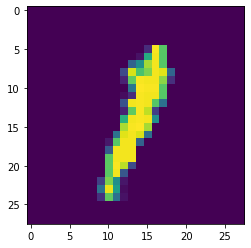

In [5]:
n_samples_train = 12000
i = np.random.randint(0, n_samples_train)
img = Image.fromarray(x_train[i])
plt.imshow(img)

y_train[i]

In [6]:
images, labels = (x_train[0:n_samples_train].reshape(n_samples_train,28*28) /255, y_train[0:n_samples_train].reshape(n_samples_train,1)) 
df = pd.DataFrame(images)
images.shape,labels.shape

((12000, 784), (12000, 1))

In [7]:
# params_ , cost_ = train(images,labels,[images.shape[1],6,4,labels.shape[1]],n_iters=2000,alpha =  0.01,lambda_=10,)
nn =NeuralNetwork(images,labels,[images.shape[1],6,4,labels.shape[1]])
nn.train()

iter: 0 cost: 0.6115906260008187 Accuracy: 0.3923333333333333
----------------------------------------------------------------------
iter: 50 cost: 0.5950251703297617 Accuracy: 0.4205
----------------------------------------------------------------------
iter: 100 cost: 0.5837137557401177 Accuracy: 0.4374166666666667
----------------------------------------------------------------------
iter: 150 cost: 0.5749964279500709 Accuracy: 0.44716666666666666
----------------------------------------------------------------------
iter: 200 cost: 0.5675407458561853 Accuracy: 0.4548333333333333
----------------------------------------------------------------------
iter: 250 cost: 0.5609009043575773 Accuracy: 0.46141666666666664
----------------------------------------------------------------------
iter: 300 cost: 0.5547203508689106 Accuracy: 0.46741666666666665
----------------------------------------------------------------------
iter: 350 cost: 0.5488684251968116 Accuracy: 0.47175
--------------

({'W1': array([[ 0.084711  ,  0.28347052,  0.20646844,  1.31068251, -0.89455887,
           0.48947478],
         [ 0.43507479,  0.23264336,  1.02314578,  0.30951966,  0.89786234,
          -0.13357303],
         [ 0.07853315,  0.44376594,  1.09958865,  2.05395184, -1.80229385,
           0.54421965],
         ...,
         [ 0.15024589,  0.16174703,  0.46744235,  1.23555275, -1.3891189 ,
           1.22364177],
         [-1.11543867,  1.73767866,  1.22206332, -1.38448188, -0.30703994,
           0.96531439],
         [ 0.18883573,  0.14356578, -1.11695953, -1.784406  , -0.25318288,
          -0.09383266]]),
  'b1': array([[-0.01339391,  0.00756043, -0.17915006, -0.02886801,  0.06793964,
           0.04232418]]),
  'W2': array([[-0.30946641,  0.94045064, -0.99621684,  1.26806439],
         [ 1.33187795,  1.2615503 , -2.51639912, -0.09347719],
         [ 0.69506282, -1.50040965, -1.29034199,  0.23277741],
         [-0.09809369,  0.68105783, -1.41483511,  0.08446405],
         [ 0.357988

Testing the Trained Neural Network

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score ,f1_score


In [14]:
n_test_samples = x_test.shape[0]
testX = x_test.reshape(n_test_samples,28*28)/255
testY = y_test.reshape(n_test_samples,1)


Threshold: 0.5
-------------test set-------------
 precision: 0.944 
 recall: 0.867 
 fl score: 0.904 
 accuracy: 0.901


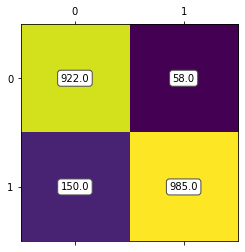

-------------train set-------------
 precision: 0.929 
 recall: 0.878 
 fl score: 0.903 
 accuracy: 0.899


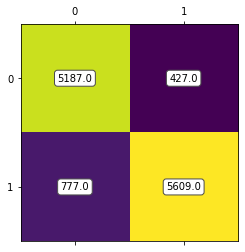

In [15]:
thres = 0.5
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)


Threshold: 0.8
-------------test set-------------
 precision: 0.959 
 recall: 0.798 
 fl score: 0.871 
 accuracy: 0.873


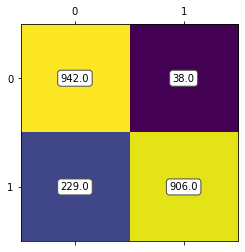

-------------train set-------------
 precision: 0.951 
 recall: 0.802 
 fl score: 0.870 
 accuracy: 0.873


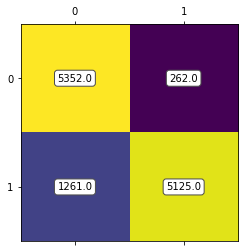

In [16]:
thres = 0.8
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.3
-------------test set-------------
 precision: 0.873 
 recall: 0.910 
 fl score: 0.891 
 accuracy: 0.881


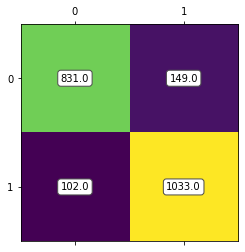

-------------train set-------------
 precision: 0.856 
 recall: 0.915 
 fl score: 0.885 
 accuracy: 0.873


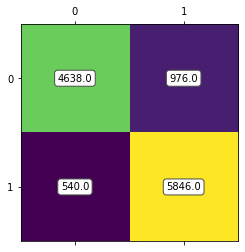

In [17]:
thres = 0.3
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.7
-------------test set-------------
 precision: 0.953 
 recall: 0.824 
 fl score: 0.884 
 accuracy: 0.884


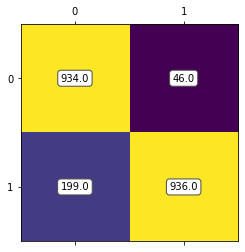

-------------train set-------------
 precision: 0.944 
 recall: 0.839 
 fl score: 0.888 
 accuracy: 0.888


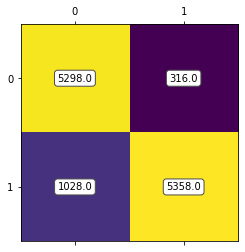

In [18]:
thres = 0.7
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)

Threshold: 0.9
-------------test set-------------
 precision: 0.968 
 recall: 0.737 
 fl score: 0.837 
 accuracy: 0.846


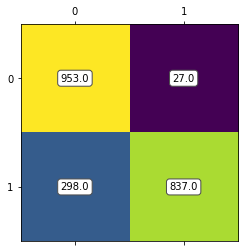

-------------train set-------------
 precision: 0.956 
 recall: 0.736 
 fl score: 0.832 
 accuracy: 0.842


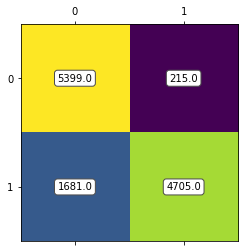

In [19]:
thres = 0.9
print("Threshold:",str(thres))
print("-------------test set-------------")
nn.evaluate(testX,testY,thres)

print("-------------train set-------------")
nn.evaluate(images,labels,thres)